---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 4

---

Please write your full name here
- **Name** : "Mahmoud Hamdy Mahmoud"

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Part 1 Autoencoders

## 1.1 Autoencoders Latent Space

The beauty of autoencoders is the possibility to see these internal representations. The bottleneck layer enforces data compression by having fewer units than input and output layers. Further limiting this layer to two or three units enables us to see how the autoencoder is organizing the data internally in two or three-dimensional latent space.

### Dataset

We will use the MNIST numbers dataset but load it using a different method
- Use tfds (tensorflow_datasets) to load the mnist numbers dataset
- In the tfds.load function:
  - Split the data into test and train
  - Shuffle the data
  - Make sure to load the labels with the data ('as_supervised' flag)


In [ ]:
# Your code here
MnistDs, info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)
(ds_train, ds_test_) = MnistDs###
# info

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds_train_proccessed = ds_train.shuffle(buffer_size=len(ds_train))
ds_test_proccessed = ds_test_.shuffle(buffer_size=len(ds_test_))
# next(iter(ds_train_proccessed))

**For ds_train**

- Fill in the missing code in 'preprocess function' to:
  - Cast the image to tf.float32
  - Normalize the image by dividing it by 255.0
- Batch the dataset
- Apply preprocess function to ds_train using 'map'
- cache and prefetch ds_train  (use tf.data.AUTOTONE)
  -  [What's caching and prefething?](https://www.tensorflow.org/guide/data_performance#prefetching)


In [ ]:
batch_size = 256


def preprocess(image, label):
    # cast image to tf.float32
    image = tf.cast(image, tf.float32)
    # normalize image
    image /= 255.0

    return image, image

# batch dataset
ds_train = ds_train_proccessed.batch(batch_size)
# apply preprocess using map
ds_train = ds_train.map(preprocess)
# cache data
ds_train = ds_train.cache()
# prefetch data
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

**For ds_test**

- Apply the same previous transformations to ds_test

In [ ]:
## Your Code here
# batch dataset
ds_test = ds_test_proccessed.batch(batch_size)
# apply preprocess using map
ds_test = ds_test.map(preprocess)
# cache data
ds_test = ds_test.cache()
# prefetch data
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

- Fill the missing code for the following function to return image and label for testing

In [ ]:
# return label for testing
def preprocess_with_label(image, label):
  #cast image to tf.float32
  image = tf.cast(image, tf.float32)
  # Normalize image by dividing by 255.0
  image /= 255.0
  # return image and label
  return image, label

# Use map to apply the above function to ds_test_ then batch (size=1000), cache and prefectch it
ds_test_label = ds_test_proccessed.map(preprocess_with_label).batch(batch_size=1000).cache().prefetch(tf.data.experimental.AUTOTUNE)

### Latent Space Visualization

The plotting functions help visualize the encoding of inputs from high dimension into 2D latent space, and decoding back to the original dimension. The functions produces two plots:

- **Encoder map** shows the mapping from input images to coordinates (z1,z2) in latent space, with digit labels displayed in colorbar

- **Decoder** **grid** shows reconstructions from a grid of latent space coordinates (z1,z2)

![Latent space visualization](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/latent_space_plots_noaxis.png)

Build **TWO** fully connected models:
1. Encoder: (1 layer only)
  - layer 0 reshape input image to a vector
  - layer 1: 64 neurons
  - layer 2: 32 neurons
  - layer 3: 16 neurons
  - layer 4/encoding_dim : 2 neurons (no activation)
  - layer 5: Batch Normalization [What?](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)
2. Decoder: (1 layer only)
  - layer 0 : 16 neurons
  - layer 1 : 32 neurons
  - layer 2 : 64 neurons
  - layer 3 : output image vector shape (sigmoid)
  - layer 4: reshape vector to a 2D image

- All layers use ReLu activation unless stated otherwise.

In [ ]:
shapeTensor = next(iter(ds_train))[0][0].shape
shapeArr = shapeTensor.as_list()
np.prod(shapeArr)

784

In [ ]:
shapeArr[0]

28

In [ ]:
from os import name
encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(shapeArr)),
    tf.keras.layers.Dense(64, activation="relu", name="Layer1"),
    tf.keras.layers.Dense(32, activation="relu", name='Layer2'),
    tf.keras.layers.Dense(16, activation="relu", name='Layer3'),
    tf.keras.layers.Dense(2, activation=None, name='Layer4'),
    tf.keras.layers.BatchNormalization(name="BatchNorm"),
], name="Encoder")

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(2,), name='Layer0'),
    tf.keras.layers.Dense(32, activation="relu", name='Layer1'),
    tf.keras.layers.Dense(64, activation="relu", name='Layer2'),
    tf.keras.layers.Dense(np.prod(shapeArr), activation="sigmoid", name='Layer3'),
    tf.keras.layers.Reshape((shapeArr), name="ReshapeLayer")
], name='Decoder')

autoencoder = tf.keras.Sequential([encoder, decoder])

In [ ]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 2)                 52890     
                                                                 
 Decoder (Sequential)        (None, 28, 28, 1)         53664     
                                                                 
Total params: 106554 (416.23 KB)
Trainable params: 106550 (416.21 KB)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________


Compile the model using adam optimizer and binary cross entropy error loss function

In [ ]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

- Train the network for `epochs=50` epochs and `validation_data=ds_test`, and visualize a few reconstructed samples.
    - Load the weights in ./checkpoints/autoencoder to your model as initial weights BEFORE training

In [ ]:
#### Your Code Here
# load the weights in ./checkpoints/autoencoder to ur built model
autoencoder.load_weights("autoencoder")
# train model
history= autoencoder.fit(ds_train, epochs=50, validation_data=(ds_test))

Epoch 1/50
235/235 [==============================] - 7s 18ms/step - loss: 0.3066 - val_loss: 0.2298
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.2252 - val_loss: 0.2200
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.2198 - val_loss: 0.2163
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2168 - val_loss: 0.2139
Epoch 5/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2145 - val_loss: 0.2120
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.2124 - val_loss: 0.2102
Epoch 7/50
235/235 [==============================] - 4s 15ms/step - loss: 0.2105 - val_loss: 0.2082
Epoch 8/50
235/235 [==============================] - 3s 14ms/step - loss: 0.2082 - val_loss: 0.2062
Epoch 9/50
235/235 [==============================] - 3s 13ms/step - loss: 0.2061 - val_loss: 0.2044
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2045 - val_lo

In [ ]:
def visualizeRec(model, images, num = 5):
  im = []
  for i in images:
    im.append(i)
  predictions = model.predict(images)
  fig = plt.figure(figsize=(num * 1.5, 3))
  for image in range(num):
    plt.subplot(2, num, 1 + image)
    plt.imshow(im[0][0][image], cmap="binary")
    plt.title("Original")
    plt.axis("off")
    plt.subplot(2, num, 1 + num + image)
    plt.imshow(predictions[image], cmap="binary")
    plt.title("Rec")
    plt.axis("off")

40/40 [==============================] - 0s 6ms/step


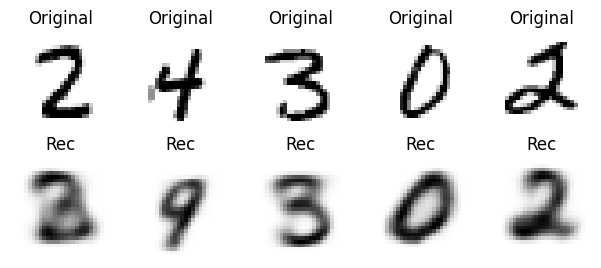

In [ ]:
#Visualize 5 reconstructed images
visualizeRec(autoencoder, ds_test)

- Load a batch of images from test set (ds_test) and display 10 of them
  - Display the original images in 1 row
  - Display their reconstruction from autoencoder in 2nd row

1/1 [==============================] - 0s 15ms/step


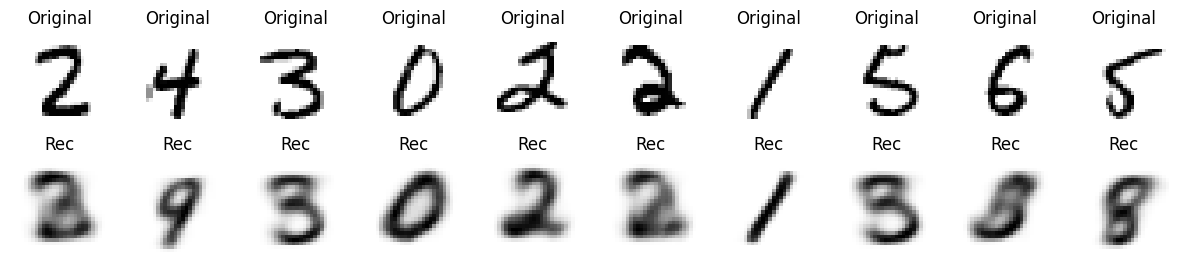

In [ ]:
## Your Code Here
visualizeRec(autoencoder, ds_test.take(1), 10) #Insert 1 batch to sample 10 predictions from it

We can use autoencoder to generate images!! Now that we have a trained autoencoder, we can ignore the encoder and use only the
decoder to sample from the latent variables to generate images. As we
did not use any activation in the last layer before the latent variables, the latent space is
unbounded and can be any real floating numbers, and there are hundreds of them!

Let's look at the latent space.
- Load a batch of images from test data with their labels (ds_test_label)
- Use the encoder model to predict their latent space dimensions

The color bar on the right indicates the intensity of
the digit labels.

32/32 [==============================] - 0s 2ms/step


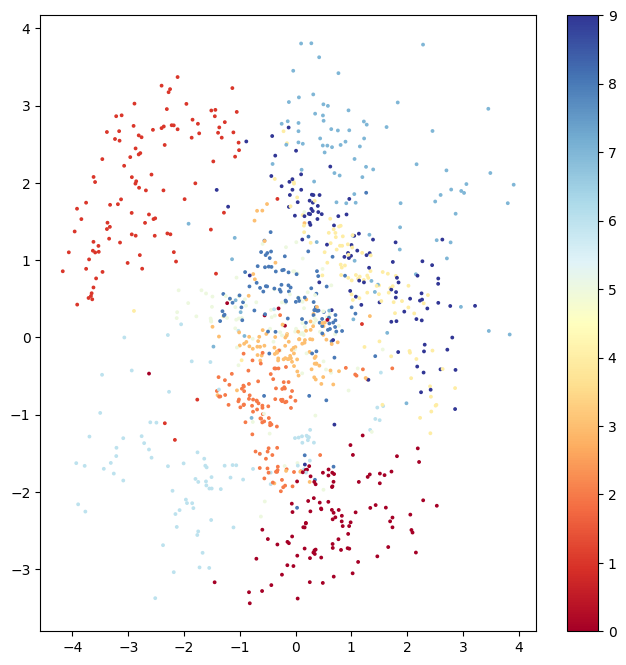

In [ ]:
## Your code here

images, labels = next(iter(ds_test_label))
z_dims = encoder.predict(images)


plt.figure(figsize=(8,8))
plt.scatter(z_dims[:,0], z_dims[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

The classes are not distributed uniformly. You can see clusters that are well separated from other classes

You might be able to see the non-uniformity better in the following images, which we will
generat by sweeping the latent variables from start of above axis to its end with a 1.0 interval

- z_samples: Create a 2D numpy array of shape (100, 2) that contains [z1, z2] values in the range (-5, 5) a 1.0 interval
- images: Use the decoder model to construct images from those embeddings (z_samples)

4/4 [==============================] - 0s 5ms/step


TypeError: ignored

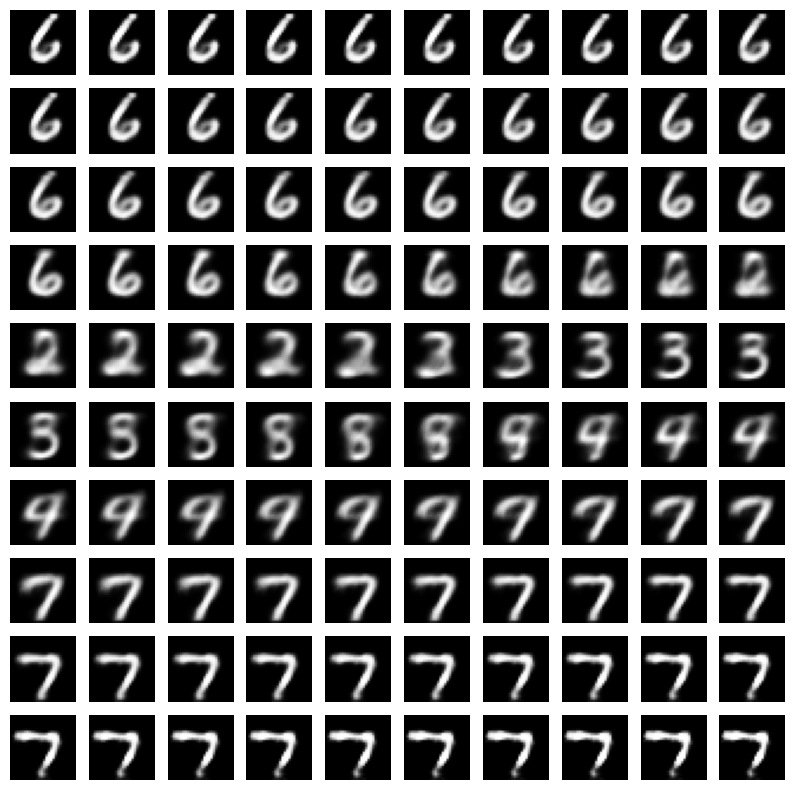

In [ ]:
## Your code here
z__samples= np.column_stack((np.linspace(-5, 5, num=100),
                            np.linspace(-5, 5, num=100)))

images = decoder.predict(z__samples)


grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()

This widget allows you to slide the latent variable
bars to generate images interactively. Have fun!

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

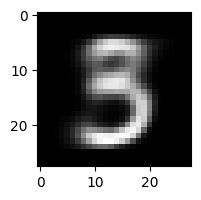

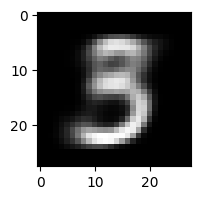

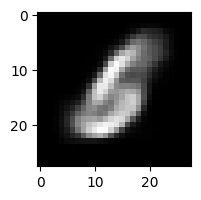

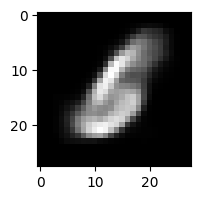

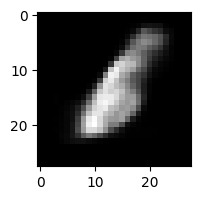

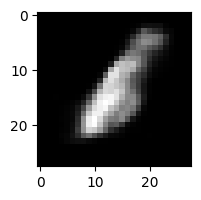

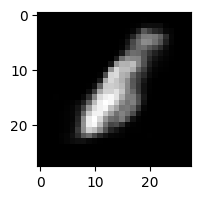

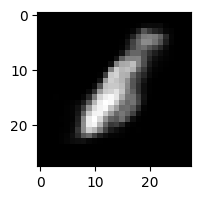

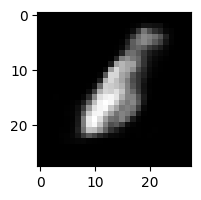

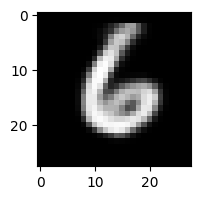

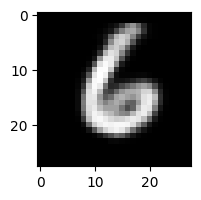

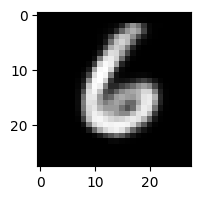

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = [[z1, z2]]
    images = decoder.predict(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:], cmap='gray')

We can see that some digits are well represented in the sample distribution and they
are nicely drawn too. It is not the case for some other digits, which are blurry, and some
digits are even missing from the samples. The latter shows the shortcoming where there is
very little variation in generated images for those classes.

## 1.2 Anomaly Detection

### Dataset

In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate **anomaly detection** concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. *You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.*

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


The last column contains the labels. The other data points are the electrocadriogram data

- Read the labels and ECG data into different variables
- Use sklearn train_test_split to split the data into **20%** test and **80%** train data
- Use random state = 21

In [ ]:
#### Your Code Here #####
labels = raw_data[:,140] ######
data = raw_data[:,:140] #####
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,test_size=0.2, random_state=21) #########

Normalize the data to [0,1] using min max normaliztion
- you might need to cast data to tf.float32
- avoid data leak

In [ ]:
######## Your Code Here #######
casted_data = tf.cast(data, tf.float32)
min_val = tf.reduce_min(casted_data,axis=0)
max_val = tf.reduce_max(casted_data,axis=0)

train_data = (train_data - min_val)/(max_val-min_val)
test_data = (test_data - min_val)/(max_val-min_val)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1.
- Separate the normal rhythms data row from the abnormal rhythms into different variables.
- Do this for both test and train data

In [ ]:
######### Your Code Here ##########
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

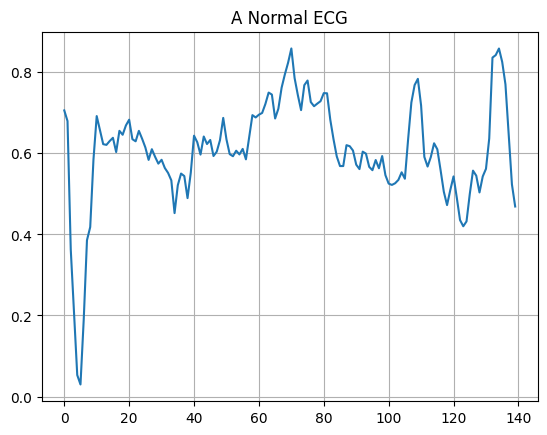

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

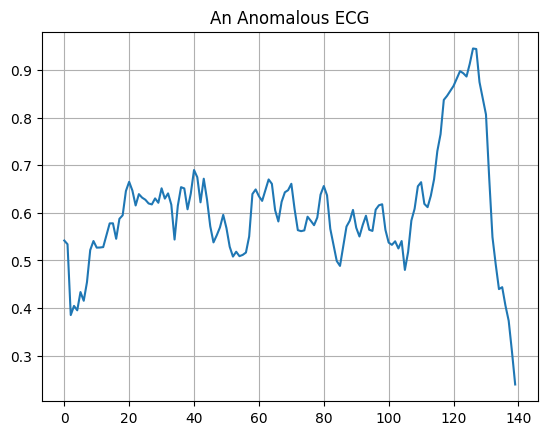

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Model

Build **TWO** fully connected models:
1. Encoder:
  - layer 1 : 32 neurons
  - layer 2 : 16 neurons
  - layer 3 : 8 neurons
2. Decoder:
  - layer 1: 16 neurons
  - layer 2: 32 neurons
  - layer 3: 140 neurons

- All layers use ReLu activation except last layer should have a sigmoid avtivation.

In [ ]:
#### Your Code Here
encoder= tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(140,), name="layer1"),
    tf.keras.layers.Dense(16, activation="relu", name="Layer2"),
    tf.keras.layers.Dense(8, activation="relu", name="Layer3")
    ],name="Encoder")
decoder= tf.keras.Sequential([
    tf.keras.layers.Dense(16, input_shape=(8,), name="layer1"),
    tf.keras.layers.Dense(32, activation="relu", name="Layer2"),
    tf.keras.layers.Dense(140, activation="sigmoid", name="Layer3")
    ],name="Decoder")
autoencoder= tf.keras.Sequential([encoder, decoder])

Compile the model using adam optimizer and mean absolute error loss function

In [ ]:
# Your code here
autoencoder.compile(optimizer='adam',loss="mae")

- Train the autoencoder using only the normal ECGs data
- Use entire test data for validation
- Use a batch size = 512
- epochs = 20
- shuffe the data

In [ ]:
#### Your Code Here
history= autoencoder.fit(normal_train_data, normal_train_data, batch_size=512,
                         shuffle=True, epochs=20, validation_data=(normal_test_data, normal_test_data))

Epoch 1/20
5/5 [==============================] - 1s 53ms/step - loss: 0.1412 - val_loss: 0.1364
Epoch 2/20
5/5 [==============================] - 0s 17ms/step - loss: 0.1348 - val_loss: 0.1304
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.1269 - val_loss: 0.1189
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.1145 - val_loss: 0.1069
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.1032 - val_loss: 0.0954
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0915 - val_loss: 0.0843
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0810 - val_loss: 0.0742
Epoch 8/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0715 - val_loss: 0.0660
Epoch 9/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0640 - val_loss: 0.0597
Epoch 10/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0583 - val_loss: 0.0550
Epoch 11/20
5/5 [============

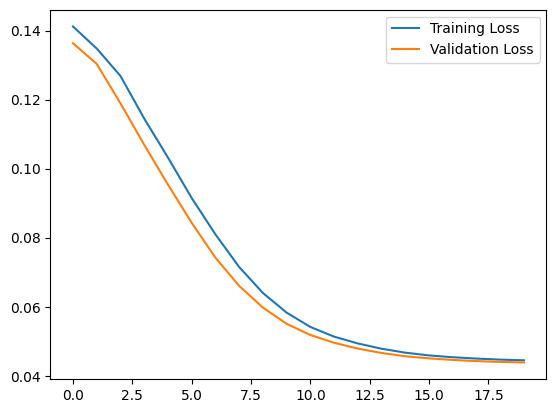

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Detect Anamolies

You will classify an ECG as anomalous if the reconstruction error is greater than **one standard deviation** from the normal training examples.

First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

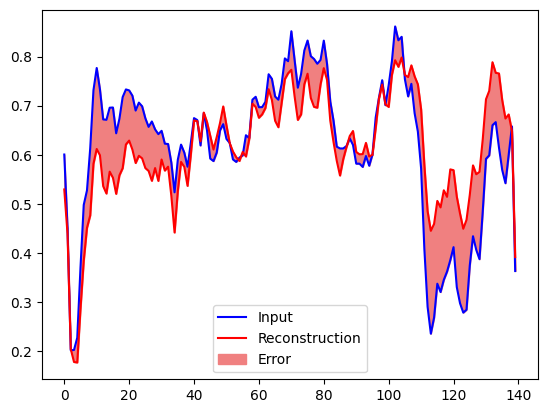

In [ ]:
encoded_data = encoder(normal_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

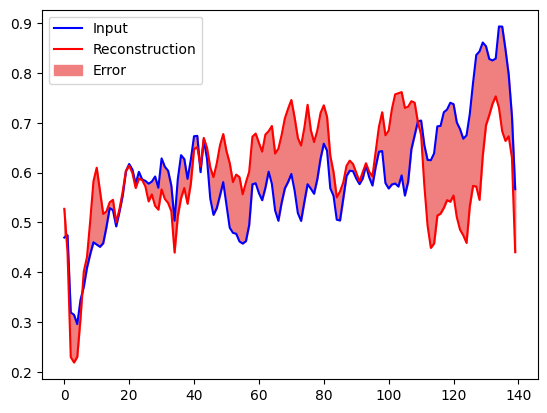

In [ ]:
##### Your Code here
encoded_data = encoder(anomalous_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Calculate the **mean average error** for normal examples from the training set, then classify future examples as anomalous if the *reconstruction error is higher than one standard deviation from the training set*.

- Predict the ECG reconstructions for **normal ECG train data** only
- Calculate the mean absolute error between the predicted reconstructions and the true ECG data (use tf.keras.losses)

74/74 [==============================] - 0s 1ms/step


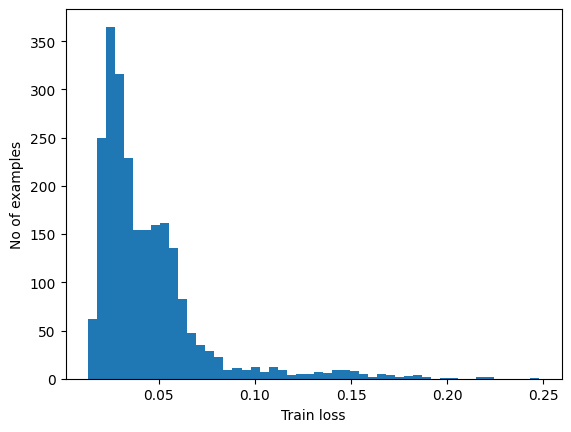

In [ ]:
from tensorflow.keras.losses import mean_absolute_error

##### Your Code Here
reconstructions = autoencoder.predict(normal_train_data)
train_loss =mean_absolute_error(reconstructions,normal_train_data)



plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

- Choose a threshold value that is one standard deviations above the mean of the train_loss you just calculated




In [ ]:
##### Your Code Here
mean =np.mean(train_loss)
std =np.std(train_loss)
threshold=mean+std

print("Threshold: ", threshold)

Threshold:  0.07305767


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this assignment.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

- Predict the ECG reconstructions for **abnormal ECG test data** only
- Calculate the mean absolute error between the predicted reconstructions and the true ECG data (use tf.keras.losses)

14/14 [==============================] - 0s 2ms/step


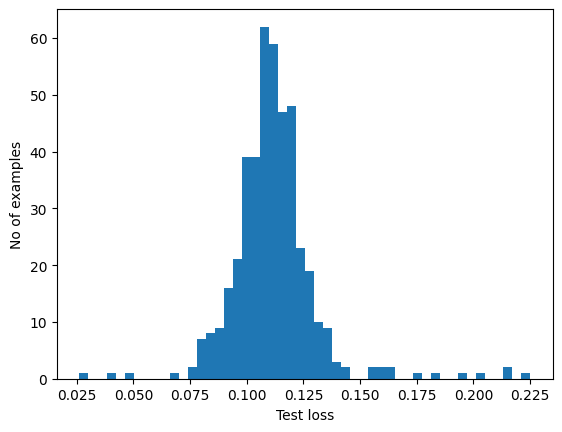

In [ ]:
### Your Code Here
reconstructions =autoencoder.predict(anomalous_test_data)
test_loss =mean_absolute_error(reconstructions,anomalous_test_data)


plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
- Fill in the missing code for the predict function to do so

In [ ]:
def predict(model, data, threshold):
  '''
  input: the model
  data: test data (contains raw data)
  threshold for anomaly classification
  '''
  ## Use model to predict reconstructions for data
  reconstructions =model.predict(data)
  ## Calculate mae loss between reconstructions and true data
  loss =mean_absolute_error(data, reconstructions)
  ## not_nomaly should contain 1 if loss < threshold and 0 otherwise
  not_anomaly =tf.where(loss < threshold, 1, 0)

  return not_anomaly

In [ ]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

Run the following cell to look at the classification acccuracy of your anomaly detection model

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

32/32 [==============================] - 0s 2ms/step
Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714


# Extra Sources
- Anomaly Detection
  - To learn more about anomaly detection with autoencoders, look at [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia.
  - For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow.